In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [47]:
from datetime import datetime 
import numpy as np
import os

def parse_std_err(fname):
   with open(fname, "r") as f:
        lines = f.readlines() 
        for line in lines:
            # GCP
            if "real" in line:
                return float(line.split()[0])
            # Azure
            elif "elapsed" in line:
                t_string = line.split(" ")[2].split("elapsed")[0]
                t = datetime.strptime(t_string, '%M:%S.%f')
                datetime.strftime(t, '%M:%S.%f')
                return t.second + 60*t.minute + 0.000001*t.microsecond

def parse_std_out(fname):
    with open(fname, "r") as f:
        lines = f.readlines()
        for line in lines:
            if "Creating a new cluster" in line:
                start_time_str = line.split(" ")[2]
                start_time = datetime.strptime(start_time_str, '%H:%M:%S')
            if "Head node is up" in line:
                end_time_str = line.split(" ")[2]
                end_time = datetime.strptime(end_time_str, '%H:%M:%S')
        total_time_seconds = float((end_time - start_time).total_seconds())
        return total_time_seconds

def plot(provision_times, times_to_head_node_up, dirname, legend):
    # Create stacked bar plot
    labels = [f"{i}" for i in range(len(provision_times))]
    x = np.arange(len(provision_times))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 2))
    ax.bar(x, times_to_head_node_up, width, label='Time to start VM')
    ax.bar(x, [provision_times[i] - times_to_head_node_up[i] for i in range(len(provision_times))], width, bottom=times_to_head_node_up, label="Add'l time to provision")

    ax.set_ylabel('Time (s)')
    ax.set_xlabel('sky-launch call index (0-39)')
    ax.set_title(f'Time to provision for sky launch ({dirname})')
    ax.set_xticks(x[::5])  # Select every 5th label
    ax.set_xticklabels(labels[::5])  # Select every 5th label
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    if legend:
        ax.legend(loc="lower right")

    #plt.savefig(f"skypilot_{dirname}.png")
    plt.show()

def process_dir(dirname, legend):
    files = os.listdir(dirname)
    provision_times = []
    times_to_head_node_up = []
    for filename in files:
        if "stderr" in filename:
            provision_times.append(parse_std_err(os.path.join(dirname, filename)))
        if "stdout" in filename:
            times_to_head_node_up.append(parse_std_out(os.path.join(dirname, filename)))
    print(f"{dirname}: {np.mean(np.array(provision_times))} (std dev {np.std(np.array(provision_times))}) s to provision (avg), {np.mean(np.array(times_to_head_node_up))} s (std dev {np.std(np.array(times_to_head_node_up))}) to head node up (avg)")
    plot(provision_times, times_to_head_node_up, dirname, legend)

In [51]:
def process_batch_times(fname):
    with open(fname, "r") as f:
        lines = f.readlines()
        times = []
        total = 0
        for line in lines:
            if "BATCH TIME (s):" in line:
                times.append(10.0/float(line.split()[-1]))
            if "TOTAL TIME (s):" in line:
                total = 40.0/float(line.split()[-1])
        return (times, total)

def plot_batch_times(baseline_fname, skydentity_fname, batch_size=10):
    baseline_times, baseline_total = process_batch_times(baseline_fname)
    baseline_times.append(baseline_total)
    print(f"Throughput (baseline): batch {np.mean(baseline_times)}, overall {baseline_total}")
    skydentity_times, skydentity_total = process_batch_times(skydentity_fname)
    skydentity_times.append(skydentity_total)
    print(f"Throughput (skydentity): batch {np.mean(skydentity_times)}, overall {skydentity_total}")
    x = np.arange(len(baseline_times)) + 2
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.bar(x, baseline_times, width, label='Baseline')
    ax.bar(x + width, skydentity_times, width, label='w/ Skydentity')
    ax.set_ylabel('Req/s')
    ax.set_title(f"Throughput ({batch_size} parallel requests)")
    ax.set_xticks(x)
    x_labels = [f"Group {i}" for i in range(len(baseline_times))]
    x_labels[-1] = "Total"
    ax.set_xticklabels(x_labels)
    ax.legend(loc="lower right")
    #plt.savefig(f"batch_times_{batch_size}.png")
    plt.show()

logs/azure_baseline/1: 450.922 (std dev 46.43719647007127) s to provision (avg), 181.3 s (std dev 11.522152576667262) to head node up (avg)


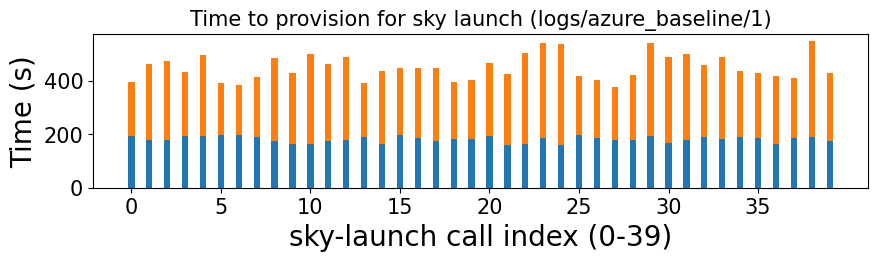

logs/azure_skydentity/1: 599.41075 (std dev 62.539520640451826) s to provision (avg), 345.15 s (std dev 55.06748132972853) to head node up (avg)


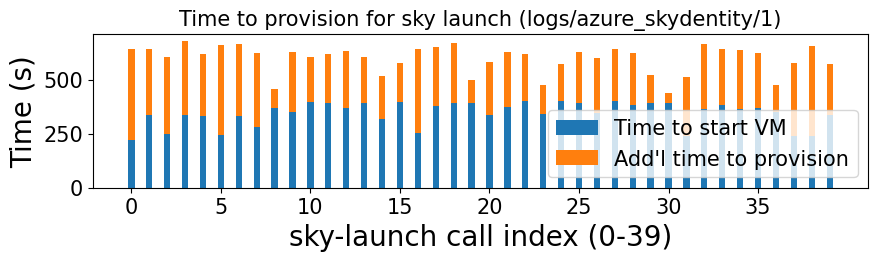

In [48]:
process_dir("logs/azure_baseline/1", False)
process_dir("logs/azure_skydentity/1", True)

Throughput (baseline): batch 0.019194745999806178, overall 0.01916113065160589
Throughput (skydentity): batch 0.015213749220321909, overall 0.015201470162914461


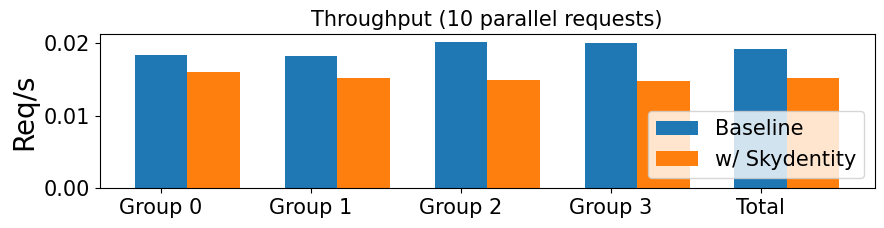

In [52]:
plot_batch_times("logs/azure_baseline/1/times.txt", "logs/azure_skydentity/1/times.txt")

logs/batch_10_baseline: 184.73975000000002 (std dev 10.041824158861775) s to provision (avg), 68.825 s (std dev 3.9679182199233898) to head node up (avg)


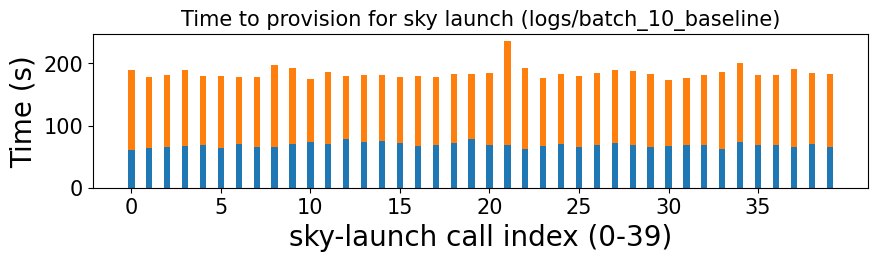

logs/batch_10_skydentity: 212.71125 (std dev 14.63113976891411) s to provision (avg), 80.25 s (std dev 5.141740950300783) to head node up (avg)


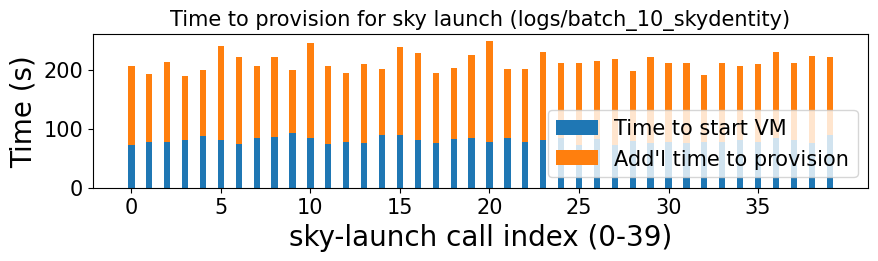

In [49]:
process_dir("logs/batch_10_baseline", False)
process_dir("logs/batch_10_skydentity", True)

Throughput (baseline): batch 0.04937556164908376, overall 0.049068412539603264
Throughput (skydentity): batch 0.04322494025184382, overall 0.04307777342596783


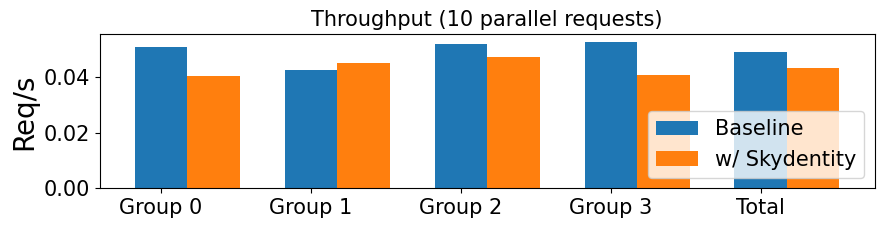

In [53]:
plot_batch_times("logs/batch_10_baseline/batch_times.txt", "logs/batch_10_skydentity/batch_times.txt")